In [3]:
import os

os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda/nvvm/libdevice/"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda/nvvm/lib64/libnvvm.so"

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
import importlib.machinery
import types
import os
import pickle
from shapely import wkt, geometry
import json
import numpy as np
from copy import deepcopy
from IPython.core.debugger import set_trace
# import sys
# sys.path.append("methods")

from transform import simplex_ft_gpu, simplex_ft_bw_gpu
from loader import poly2ve

from AFNet import AFNet


import pandas as pd

# class PolyMNIST(object):
#     def __init__(self, path):
#         with open(os.path.join(path, "mnist_polygon_test.json"), 'r') as infile:
#             self.plist = json.load(infile)
#         with open(os.path.join(path, "mnist_label_test.json"), 'r') as infile:
#             self.label = json.load(infile)
#     def __getitem__(self, idx):
#         P = wkt.loads(self.plist[idx])
#         V, E = poly2ve(P)
#         return V, E, self.label[idx]
    
#     def get_poly(self, idx):
#         P = wkt.loads(self.plist[idx])
#         return P
    
#     def get_label(self, idx):
#         return self.label[idx]
      
class PolyAirfoils(object):
    def __init__(self, path):
        with open(os.path.join(path, "airfoil_polygons.json"), 'r') as infile:
            self.plist = json.load(infile)
        with open(os.path.join(path, "airfoil_ClCd.json"), 'r') as infile:
            self.ClCd = json.load(infile)
    def __getitem__(self, idx):
        P = wkt.loads(self.plist[idx])
        V, E = poly2ve(P)
        return V, E, self.label[idx]
    
    def get_poly(self, idx):
        P = wkt.loads(self.plist[idx])
        return P
    
    def get_ClCd(self, idx):
        return self.ClCd[idx]


class ShapeOptimizer(object):
    def __init__(self, polygon, C, model, cfd_data, target, device):
        """
        object for optimizing polygonal shapes (MNIST experiment)
        params:
        polygon: shapely Polygon or MultiPolygon object.
        C: shape (#C, 2) control points
        model: trained pytorch model for inference.
        Re: Reynolds number
        target: int. target class to convert to.
        device: pytorch device type
        """
        self.CPoly = CPolygon(polygon, C)
        self.V = self.CPoly.V
        self.E = self.CPoly.E
        self.polygon = [polygon]
        self.D = np.ones((self.E.shape[0], 1))
        self.model = model
        self.cfd_data=cfd_data
        self.target_tensor = torch.tensor(target).view(-1,1).to(device)
        self.dV = None
        self.dC = None
        self.res = 224
        self.profile = {"loss": [],
                        "ClCd": []}
        
    def step(self, step_size=1e-3, sign=-1, stochastic=False):
        '''
        combines _get_grad and _step.
        sign = 1 for maximizing score
        sign = -1 for minimizing score
        '''
#         set_trace()
        assert(sign==1 or sign==-1)
        self._get_grad()
        self._step(step_size=step_size, sign=sign, stochastic=stochastic)

    def _step(self, step_size=1e-3, sign=-1, stochastic=False):
        """
        Take a step toward gradient direction. 
        params:
        step_size: gradient step size
        sign: 1 or -1, to go maximize or minimize value
        check: bool. whether to enforce no-intersection constraint
        shuffle: whether to traverse points in random order during checked updates
        """
        dC = self.dC.copy()
        if not stochastic:
            dC[:, -1] *= 100
#             print(sign * step_size * dC)
            self.CPoly.update_control(sign * step_size * dC)
        else:
            dC = np.sign(dC)
            dC[:, -1] *= 30
            self.CPoly.update_control(sign * step_size * dC)
        self.V = self.CPoly.V
        self.polygon.append(deepcopy(self.CPoly.polygon))

    def _get_grad(self):
        """
        Compute gradient of loss function w.r.t. into vertices
        params:
        self
        """
        # compute frequencies from V, E
        
        Freq = simplex_ft_gpu(self.V, self.E, self.D, (self.res, self.res), t=(1,1), j=2)
        Freq = np.squeeze(Freq)
#         half = int(self.res/2+1)
#         Freq = np.concatenate((Freq[:half], Freq[half+2:]), axis=0)
        Freq = np.stack([np.real(Freq), np.imag(Freq)], axis=-1).astype(np.float32)
#         Freq = np.expand_dims(np.expand_dims(Freq, 0), 0) # pad to shape (batch(1), channel(1), res, res)
        Freq = np.expand_dims(Freq, 0) # pad to shape (batch(1), res, res)
        Freq=np.concatenate((Freq,torch.zeros(Freq.shape[0], Freq.shape[1], 1, Freq.shape[3])), axis=2)
        F_ten = torch.tensor(Freq, requires_grad=True)    
        
#         Freq = simplex_ft_gpu(self.V, self.E, self.D, (self.res+2, self.res+2), t=(1,1), j=2)
#         Freq = np.squeeze(Freq)
#         half = int(self.res/2+1)
#         Freq = np.concatenate((Freq[:half], Freq[half+2:]), axis=0)
#         Freq = np.stack([np.real(Freq), np.imag(Freq)], axis=-1).astype(np.float32)
#         Freq = np.expand_dims(np.expand_dims(Freq, 0), 0) # pad to shape (batch(1), channel(1), res, res)
#         print(Freq.shape)
#         F_ten = torch.tensor(Freq, requires_grad=True)

        # compute loss wrt. target class
        self.model.eval()  
        self.model.zero_grad()  
        criterion=nn.MSELoss()
        output=self.model(F_ten, self.cfd_data)  
        loss = criterion(output,self.target_tensor)  
        loss.backward()  
#         for name, param in self.model.named_parameters():
#             print(name,param.data)
        self.profile['loss'].append(loss.item()) # save loss at current iteration
        self.profile['ClCd'].append(output.item())

        # compute grad on V
#         print(F_ten.grad.detach().cpu().numpy())
        dF = np.squeeze(F_ten.grad.detach().cpu().numpy()) # shape (28, 15, 2 (real+imag)) (256,129,2)
        dF = dF[..., 0] + (1j)*dF[..., 1]
        dF = dF[:, :-1] # shape (28, 14) (256,128)
        dF = np.expand_dims(dF, axis=-1) # shape (28, 14, 1) (256,128,1)
  
        self.dV = simplex_ft_bw_gpu(dF, self.V, self.E, self.D, (self.res, self.res), t=(1,1), j=2)
        self.dV = self.dV[:self.V.shape[0]]
      
        # compute grad on C
        dVdC = self.CPoly.dVdC
        self.dC = np.einsum("ijkl,ij->kl", dVdC, self.dV)
#         print(dF)
        
#         print(np.max(self.dV))
        
#         print(np.max(self.dC))
        
                
        
class CPolygon(object):
    def __init__(self, polygon, C):
        self.polygon = polygon
        self.V, self.E, self.E_segs = self.getVE()
        self.npoly = len(self.E_segs)
        self.C = C
        self.W = None # shape (#V, #C)
        self.dVdC = None # shape (#V, 2, #C, 3)
        self._update_weights()
        
    def update_control(self, dC, rad=True):
        """dC: shape (#C, 3), where 3 dims are x, y, theta"""
        assert(self.C.shape[0] == dC.shape[0])
        dtheta = dC[:, 2].copy()
#         dtheta=np.zeros_like(dC[:,2]);
        dC = dC[:, :2].copy()
        if not rad:
            dtheta = dtheta / 180 * np.pi
        Vnew = np.zeros_like(self.V)
        for i in range(dtheta.shape[0]):
            t = dtheta[i]
            Rot = np.array([[np.cos(t), -np.sin(t)],
                            [np.sin(t), np.cos(t)]])
            a, b = self.C[i]
            Rot_trans = np.array([-a*np.cos(t)+b*np.sin(t)+a,
                                  -a*np.sin(t)-b*np.cos(t)+b])
           
            Vnew += self.W[:, i:i+1] * (self.V.dot(Rot.T) + dC[i] + Rot_trans)
        self.V = Vnew # update vertices
        self.C += dC # update control points
        self.polygon = self.newPolygon(self.V) # update polygon
        self._update_weights() # update weights and sensitivity matrix

    def _update_weights(self):
        self.W = np.zeros([self.V.shape[0], self.C.shape[0]])
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                v = self.V[i]
                c = self.C[j]
                self.W[i,j] = 1/(np.linalg.norm(c-v)**2)
        # normalize
        self.W = (self.W.T / np.sum(self.W, axis=1)).T
        # compute sensitivity matrix
        nV = self.V.shape[0]
        nC = self.C.shape[0]
        self.dVdC = np.zeros([nV, 2, nC, 3])
        vx, vy = self.V[:, 0:1], self.V[:, 1:2]
        cx, cy = self.C[:, 0], self.C[:, 1]
        # d vx / d cx
        self.dVdC[:, 0, :, 0] = self.W
        # d vy / d cy
        self.dVdC[:, 1, :, 1] = self.W
        # d vx / d ctheta
        self.dVdC[:, 0, :, 2] = self.W * (-vy+cy)
        # d vy / d ctheta
        self.dVdC[:, 1, :, 2] = self.W * (vx-cx)
        
        
    def edgeList(self, startid, length, flip=False):
        # helper function to create edge list
        p1 = np.arange(startid, startid+length)
        p2 = p1 + 1
        p2[-1] = startid
        if not flip:
            return np.stack((p1, p2), axis=-1)
        else:
            return np.flipud(np.stack((p2, p1), axis=-1))
        
    def singlePolygon(self, P):
        # helper function for processing a single polygon instance
        assert(isinstance(P, geometry.polygon.Polygon))
        v = []
        e = []
        ecount = 0
        # exterior
        v_ex = np.array(P.exterior)[:-1]
        e_ex = self.edgeList(0, v_ex.shape[0])
        v.append(v_ex)
        e.append(e_ex)
        ecount += v_ex.shape[0]
        # interiors
        for int_ in P.interiors:
            v_in = np.array(int_)
            e_in = self.edgeList(ecount, v_in.shape[0], flip=False)
            v.append(v_in)
            e.append(e_in)
            ecount += v_in.shape[0]
        v = np.concatenate(v, axis=0)
        e_segs = e
        e = np.concatenate(e, axis=0)
        if not P.exterior.is_ccw:
            e = np.concatenate([e[:, 1:2], e[:, 0:1]], axis=-1) # flip e
        return v, e, e_segs
    
    def getVE(self):
        E_segs = []
        if isinstance(self.polygon, geometry.polygon.Polygon):
            V, E, e_segs = self.singlePolygon(self.polygon)
            E_segs.append(e_segs)
        elif isinstance(self.polygon, geometry.multipolygon.MultiPolygon):
            V = []
            E = []
            E_segs = []
            ecount = 0
            for P in self.polygon.geoms:
                v, e, e_segs = self.singlePolygon(P)
                V.append(v)
                E.append(e+ecount)
                for s in e_segs:
                    s += ecount
                E_segs.append(e_segs)
                ecount += v.shape[0]
            V = np.concatenate(V, axis=0)
            E = np.concatenate(E, axis=0)
            
        return V, E, E_segs
    
    def newPolygon(self, V):
        np.testing.assert_array_equal(V.shape, self.V.shape)
        polys = []
        for loops in self.E_segs:
            # exterior loop
            ext_loop = loops[0][:, 0]
            ext_v = geometry.asLinearRing(V[ext_loop])
            ints_v = []
            for i in range(1, len(loops)):
                int_loop = loops[i][:, 0]
                int_v = geometry.asLinearRing(V[int_loop])
                ints_v.append(int_v)
            poly = geometry.Polygon(ext_v, ints_v)
            polys.append(poly)
        if len(polys) == 1:
            return polys[0]
        else:
            return geometry.MultiPolygon(polys)
            

In [122]:
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from numpy import asarray, concatenate, ones
from shapely.geometry import *

def ring_coding(ob):
    # The codes will be all "LINETO" commands, except for "MOVETO"s at the
    # beginning of each subpath
    n = len(ob.coords)
    codes = ones(n, dtype=Path.code_type) * Path.LINETO
    codes[0] = Path.MOVETO
    return codes

def pathify(polygon):
    # Convert coordinates to path vertices. Objects produced by Shapely's
    # analytic methods have the proper coordinate order, no need to sort.
    vertices = concatenate(
                    [asarray(polygon.exterior)]
                    + [asarray(r) for r in polygon.interiors])
    codes = concatenate(
                [ring_coding(polygon.exterior)]
                + [ring_coding(r) for r in polygon.interiors])
    return Path(vertices, codes)

def showPolygon(polygon):
    fig = plt.figure(num=1, figsize=(4, 4))
    ax = fig.add_subplot(111)

    path = pathify(polygon)
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')

    ax.add_patch(patch)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1.0)
    
    return fig, ax    

In [123]:
# Load CFD datafiles
filepath='processed-data-224'
df=pd.read_csv(os.path.join(filepath, 'airfoil_data_normalized.csv')).drop(columns=['Unnamed: 0'])
df_orig=pd.read_csv(os.path.join(filepath, 'airfoil_data.csv')).drop(columns=['Unnamed: 0'])
stats=pd.read_csv(os.path.join(filepath, 'airfoil_data_mean_std.csv')).drop(columns=['Unnamed: 0'])
mean=stats['mean']
std=stats['std']

Original Cl/Cd: 0.0


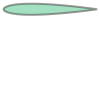

In [159]:
# parse arguments
parser = argparse.ArgumentParser(description='MNIST shape optimization')
parser.add_argument('-l', '--logdir', type=str, default="log_11-08-2018_12-08-32", help='log directory path')
parser.add_argument('-s', '--step_size', type=float, default=1e-3, help='step size for shape optimization')
parser.add_argument('--no_cuda', action='store_true', help='do not use cuda')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')

args = parser.parse_args('')

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

# Load the model
# loader = importlib.machinery.SourceFileLoader('LeNet5', os.path.join(args.logdir, "model.py"))
# mod = types.ModuleType(loader.name)
# loader.exec_module(mod)

# model = mod.LeNet5(mean=MEAN, std=STD)
model=AFNet(bottleneck=1000)
if use_cuda:
    model = nn.DataParallel(model)
model.to(device)
state=torch.load(os.path.join(args.logdir,"AFNet_model.checkpoint"))
model.load_state_dict(state['model'])
optimizer=torch.optim.Adam(model.parameters())
optimizer.load_state_dict(state['optim'])

# Shape Optimization
pairfoils = PolyAirfoils("polyairfoils")
P = pairfoils.get_poly(3)
ClCd = pairfoils.get_ClCd(3)
# control points
# NACA 0012
C = np.array([[0.02, 0],
             [0.06, 0.03],
             [0.16, 0.05],
             [0.32, 0.056],
             [0.48, 0.05],
             [0.64, 0.037],
             [0.79, 0.022],
             [0.98, 0],
             [0.06, -0.03],
             [0.16, -0.05],
             [0.32, -0.056],
             [0.48, -0.05],
             [0.64, -0.037],
             [0.79, -0.022],
             ])*.85+np.array([[0.06, 0.5]])


# C = np.array([[0.02, 0],
#              [0.1, 0.041],
#              [0.32, 0.056],
#              [0.56, 0.044],
#              [0.79, 0.022],
#              [0.98, 0],
#              [0.1, -0.041],
#              [0.32, -0.056],
#              [0.56, -0.044],
#              [0.79, -0.022]])*.85+np.array([[0.06, 0.5]])


# C = np.array([[0.02, 0],
#              [0.03, 0.017],
#              [0.06, 0.03],
#              [0.1, 0.041],
#              [0.16, 0.05],
#              [0.24, 0.055],
#              [0.32, 0.056],
#              [0.40, 0.054],
#              [0.48, 0.05],
#              [0.56, 0.044],
#              [0.64, 0.037],
#              [0.72, 0.03],
#              [0.79, 0.022],
#              [0.86, 0.014],
#              [0.92, 0.006],
#              [0.98, 0],
#              [0.03, -0.017],
#              [0.06, -0.03],
#              [0.1, -0.041],
#              [0.16, -0.05],
#              [0.24, -0.055],
#              [0.32, -0.056],
#              [0.40, -0.054],
#              [0.48, -0.05],
#              [0.56, -0.044],
#              [0.64, -0.037],
#              [0.72, -0.03],
#              [0.79, -0.022],
#              [0.86, -0.014],
#              [0.92, -0.006]
#              ])*.85+np.array([[0.06, 0.5]])

# ELLIPSE
# C = np.array([[0.1, 0.45],
#              [0.15, 0.52],
#              [0.25, 0.565],
#              [0.35, 0.59],
#              [0.5, 0.6],
#              [0.65, 0.59],
#              [0.75, 0.565],
#              [0.84, 0.52],
#              [0.9, 0.45],
#              [0.15, 0.9-0.52],
#              [0.25, 0.9-0.565],
#              [0.35, 0.9-0.59],
#              [0.5, 0.9-0.6],
#              [0.65, 0.9-0.59],
#              [0.75, 0.9-0.565],
#              [0.84, 0.9-0.52],
#              ])

# C = np.array([[0.1, 0.45],
#              [0.25, 0.565],
#              [0.5, 0.6],
#              [0.75, 0.565],
#              [0.9, 0.45],
#              [0.25, 0.9-0.565],
#              [0.5, 0.9-0.6],
#              [0.75, 0.9-0.565],
#              ])

# Weird NACA
# C = np.array([[0.1, 0.54],
#              [0.2, 0.58],
#              [0.35, 0.61],
#              [0.5, 0.615],
#              [0.63, 0.6],
#              [0.75, 0.57],
#              [0.85, 0.53],
#              [0.7, 0.55],
#              [0.55, 0.56],
#              [0.43, 0.55],
#              [0.3, 0.53],
#              [0.15, 0.51]])

# E 387
# C = np.array([[0.12, 0.525],
#              [0.2, 0.55],
#              [0.36, 0.567],
#              [0.54, 0.554],
#              [0.69, 0.532],
#              [0.84, 0.508],
#              [0.67, 0.507],
#              [0.5, 0.503],
#              [0.33, 0.497],
#              [0.16, 0.491],
#              [0.09, 0.505],
#              ])
print("Original Cl/Cd: {}".format(ClCd))

Re=1e6
aoa=0
Re_in=torch.tensor((Re-mean[1])/std[1]).view(-1,1)
aoa_in=torch.tensor((aoa-mean[0])/std[0]).view(-1,1)
cfd_data=torch.cat((Re_in, aoa_in), 1)

optim = ShapeOptimizer(P, C, model, cfd_data=cfd_data, target=2.0, device=device)
# optim = ShapeOptimizer(P, C, model, cfd_data=cfd_data, target=1.3432585776697898, device=device) # Target is Cl/Cd of Eppler 387 airfoil at aoa=0 deg and Re=1e6
# optim = ShapeOptimizer(P, C, model, Re=1.6491658736962094, target=-0.5883260814307871, device=device) # Target is Cl/Cd of NACA 0012 airfoil at aoa=0 deg and Re=1e6
optim.polygon[0]

In [160]:

%matplotlib inline

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

savefile='optim/optim16'

fig, ax = showPolygon(optim.polygon[-1])
plt.close()

def update(frame_number):
    if frame_number > 0:
        optim.step(2e-5, sign=-1, stochastic=False)   
    path = pathify(optim.polygon[-1])
    patch = PathPatch(path, facecolor='#339966', edgecolor='#999999')
    ax.cla()
    ax.add_patch(patch)
    if frame_number > 0:
        ClCd=optim.profile['ClCd'][-1]*std[4]+mean[4]
        title = "Iter: {}, Loss: {:_<6f}, Pred: {:_<6f}".format(frame_number, optim.profile['loss'][-1], ClCd)
        x,y=optim.polygon[-1].exterior.xy
        np.savetxt(savefile+str(frame_number).zfill(3)+'.txt',pd.DataFrame([x,y]).transpose().values)
    else:
        title = "Iter: {0}".format(frame_number)
    ax.set_title(title)
    print(title)
anim = animation.FuncAnimation(fig, update, interval=100, frames=50)

rc('animation', html='jshtml')
anim
# save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=1800)
anim.save(savefile+'.mp4', writer=writer)

# save loss and pred
pd.DataFrame(optim.profile).to_csv(savefile+'.csv')


Iter: 0
Iter: 0
Iter: 1, Loss: 5.921032, Pred: 5.743643
Iter: 2, Loss: 5.047019, Pred: 12.663771
Iter: 3, Loss: 4.072509, Pred: 21.130949
Iter: 4, Loss: 3.011006, Pred: 31.610487
Iter: 5, Loss: 2.504615, Pred: 37.265890
Iter: 6, Loss: 2.483830, Pred: 37.509718
Iter: 7, Loss: 2.074403, Pred: 42.539309
Iter: 8, Loss: 1.719474, Pred: 47.318920
Iter: 9, Loss: 1.406815, Pred: 51.957850
Iter: 10, Loss: 1.266097, Pred: 54.213769
Iter: 11, Loss: 1.145578, Pred: 56.247746
Iter: 12, Loss: 0.869196, Pred: 61.361517
Iter: 13, Loss: 0.617890, Pred: 66.780491
Iter: 14, Loss: 0.184601, Pred: 79.986690
Iter: 15, Loss: 0.119880, Pred: 83.077506
Iter: 16, Loss: 0.073596, Pred: 85.854750
Iter: 17, Loss: 0.045364, Pred: 88.014915
Iter: 18, Loss: 0.035326, Pred: 88.942558
Iter: 19, Loss: 0.028587, Pred: 89.641949
Iter: 20, Loss: 0.025455, Pred: 89.995117
Iter: 21, Loss: 0.022755, Pred: 90.317462
Iter: 22, Loss: 0.019178, Pred: 90.775510
Iter: 23, Loss: 0.016752, Pred: 91.111009
Iter: 24, Loss: 0.014184, Pr

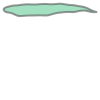

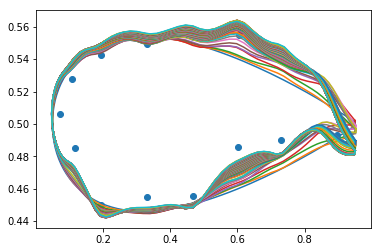

In [152]:
for i in range(0,len(optim.polygon)):
  x,y=optim.polygon[i].exterior.xy
  plt.plot(x,y)
plt.scatter(C[:,0], C[:,1])
# plt.ylim([0,1])
# plt.xlim([0,1])
optim.polygon[-1]

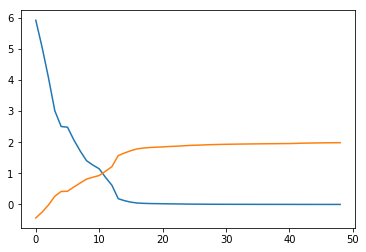

In [161]:
start=0
plt.plot(optim.profile['loss'][start:])
plt.plot(optim.profile['ClCd'][start:])